Classification

In [52]:
final_csv_url = 'https://raw.githubusercontent.com/HeedfulMoss/ML-F1-Prediction-Project/a15832797a52f3e86c12e3dc29c0dfc027a827bf/models/final_df.csv'

In [53]:
data = pd.read_csv(final_csv_url)
data.head()

,year,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driverRef,grid,position,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1983,1,False,False,True,False,False,keke_rosberg,1,15,...,0,0,0,0,0,0,0,0,0,1
1,1983,1,False,False,True,False,False,prost,2,6,...,0,0,0,1,0,0,0,0,0,0
2,1983,1,False,False,True,False,False,tambay,3,4,...,0,0,0,0,0,0,0,0,0,0
3,1983,1,False,False,True,False,False,piquet,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1983,1,False,False,True,False,False,warwick,5,7,...,0,0,0,0,0,0,0,0,0,0


# Models with Logistic Regression, SVM, and FNN.

Classification Report for logistic:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      2479
           1       0.41      0.09      0.15       116

    accuracy                           0.95      2595
   macro avg       0.68      0.54      0.56      2595
weighted avg       0.93      0.95      0.94      2595



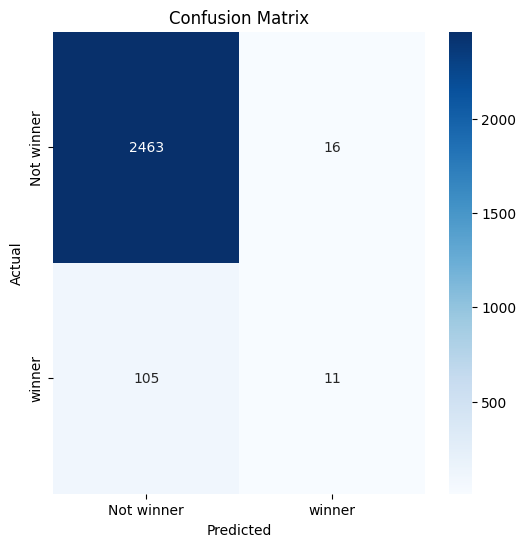

R^2 Score: 0.1400


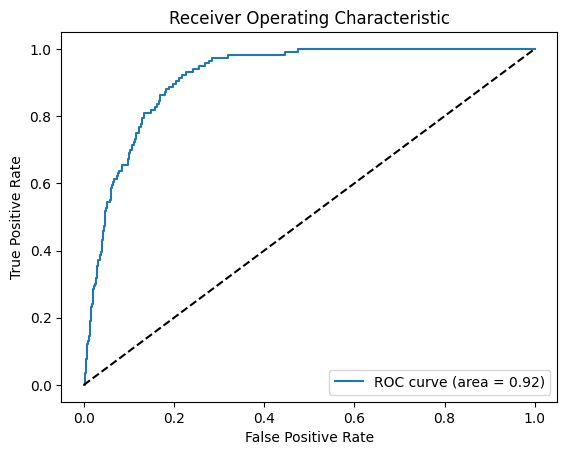

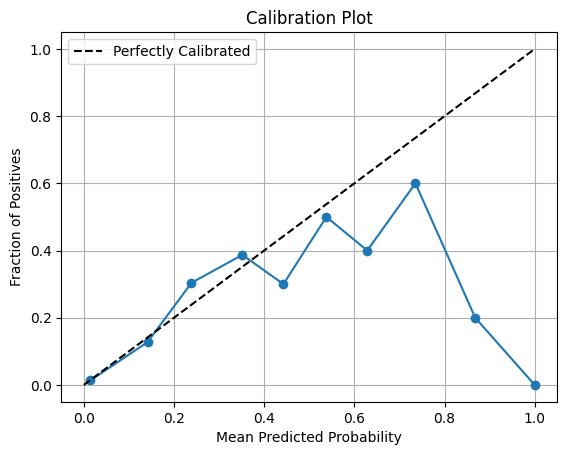

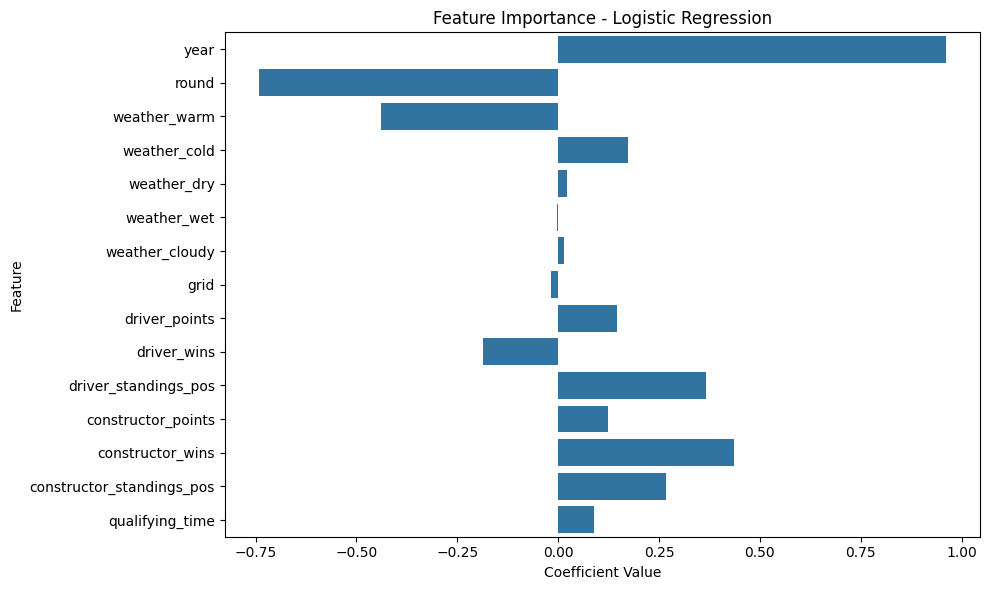

Logistic Regression Test Accuracy: 0.0000
Classification Report for svm:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2479
           1       0.20      0.01      0.02       116

    accuracy                           0.95      2595
   macro avg       0.58      0.50      0.50      2595
weighted avg       0.92      0.95      0.93      2595



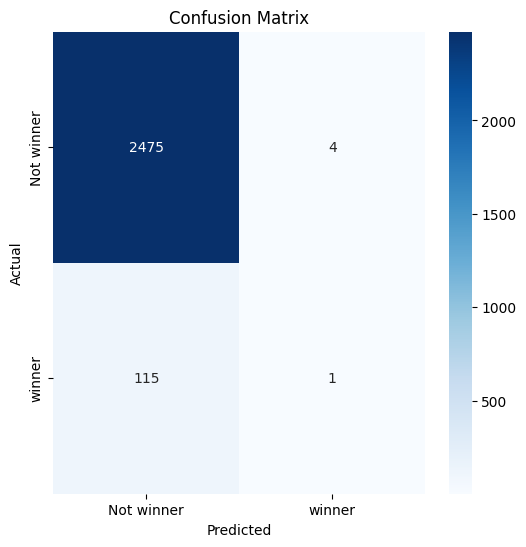

R^2 Score: -0.4270


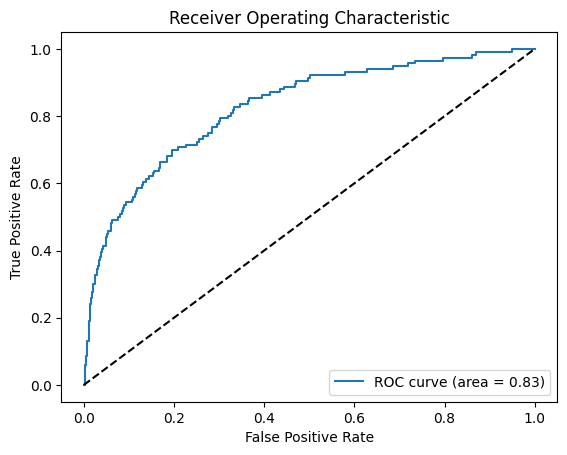

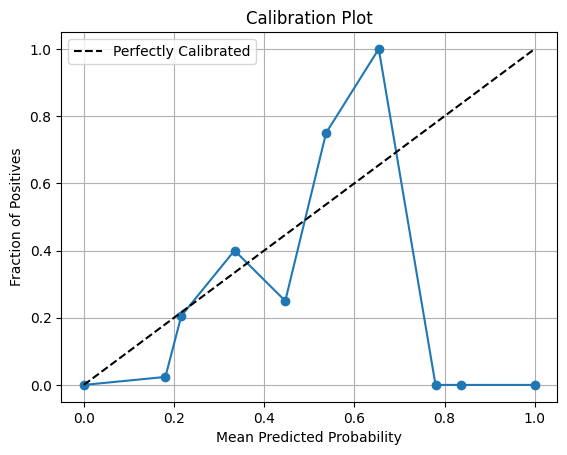

SVM Test Accuracy: 0.0000
Epoch 50/500, Train Loss: 0.6635, Validation Loss: 0.6632, Train Accuracy: 0.7393, Validation Accuracy: 0.7343
Epoch 100/500, Train Loss: 0.5537, Validation Loss: 0.5523, Train Accuracy: 0.8380, Validation Accuracy: 0.8357
Epoch 150/500, Train Loss: 0.4744, Validation Loss: 0.4743, Train Accuracy: 0.8578, Validation Accuracy: 0.8573
Epoch 200/500, Train Loss: 0.4526, Validation Loss: 0.4520, Train Accuracy: 0.8682, Validation Accuracy: 0.8685
Epoch 250/500, Train Loss: 0.4416, Validation Loss: 0.4400, Train Accuracy: 0.8783, Validation Accuracy: 0.8817
Epoch 300/500, Train Loss: 0.4340, Validation Loss: 0.4320, Train Accuracy: 0.8833, Validation Accuracy: 0.8871
Epoch 350/500, Train Loss: 0.4280, Validation Loss: 0.4261, Train Accuracy: 0.8928, Validation Accuracy: 0.8958
Epoch 400/500, Train Loss: 0.4232, Validation Loss: 0.4217, Train Accuracy: 0.8952, Validation Accuracy: 0.8988
Epoch 450/500, Train Loss: 0.4193, Validation Loss: 0.4181, Train Accuracy: 0.9

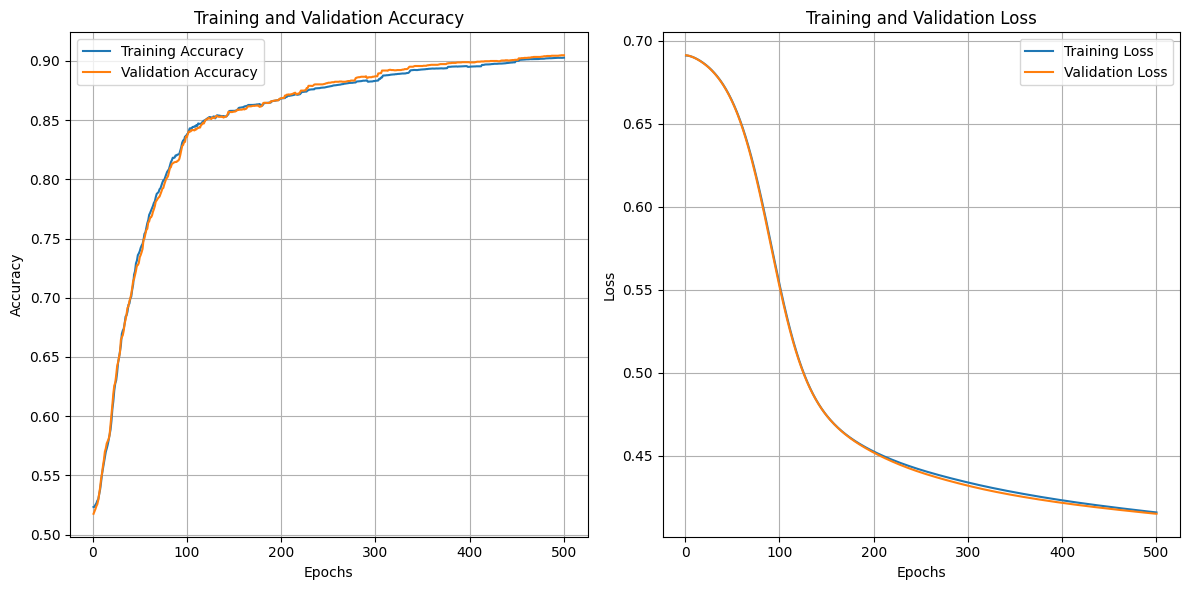

Classification Report for nn:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      2504
           1       0.86      0.97      0.91      2456

    accuracy                           0.90      4960
   macro avg       0.91      0.91      0.90      4960
weighted avg       0.91      0.90      0.90      4960



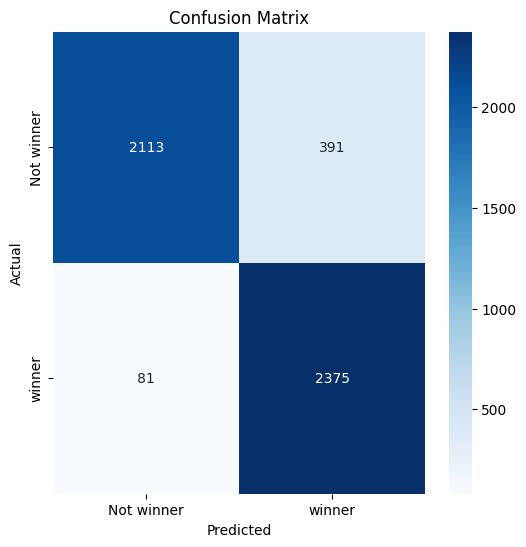

R^2 Score: 0.6660


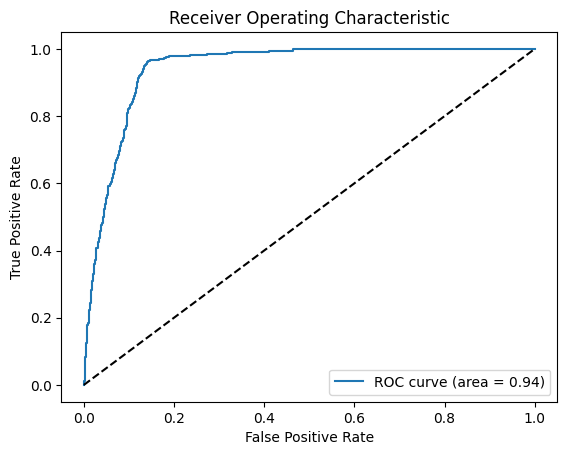

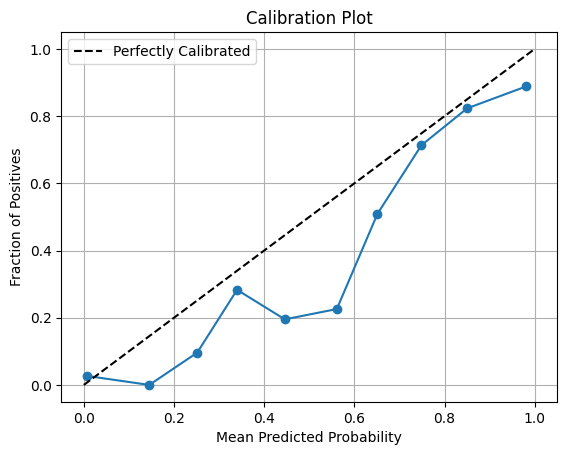

fnn Test Accuracy: 0.0000


In [59]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score, roc_curve, auc, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.base")

# Custom scoring function with updated logic
def testing_function(model, model_type='nn'):
    accuracy = 0
    successful_circuits = 0
    total_circuits = 0
    output_dir = f'testing_{model_type}'
    os.makedirs(output_dir, exist_ok=True)

    for circuit in df[df.year == 2019]['round'].unique():
        test = df[(df.year == 2019) & (df['round'] == circuit)]
        X_test = test.drop(['driverRef', 'position'], axis=1)
        y_test = test['position']  # Access original position values

        # Get position information from the 'data' dataframe
        test_position = data[(data['round'] == circuit) & (data['year'] == 2019)][['driverRef', 'position']]

        # Scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        if model_type == 'logistic':
            X_test = pca.transform(X_test)  # Apply PCA for logistic regression
            proba = model.predict_proba(X_test)  # Logistic Regression probability
        elif model_type == 'svm':
            X_test = pca.transform(X_test)  # Apply PCA for SVM
            proba = model.decision_function(X_test)  # Use decision function for SVM
            proba = (proba - proba.min()) / (proba.max() - proba.min())  # Normalize to [0, 1]
            proba = np.column_stack((1 - proba, proba))  # Simulate probability columns
        else:
            X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
            with torch.no_grad():
                predictions = model(X_test_tensor)
                proba = predictions.numpy()

        test_model_df = pd.DataFrame(proba, columns=['proba_0', 'proba_1'])
        test_model_df['actual'] = y_test.reset_index(drop=True)
        test_model_df = test_model_df.join(test_position.reset_index(drop=True))  # Add driver and original position info
        test_model_df.sort_values('proba_1', ascending=False, inplace=True)
        test_model_df.reset_index(inplace=True, drop=True)
        test_model_df['predicted'] = test_model_df.index
        test_model_df['predicted'] = test_model_df.predicted.map(lambda x: 1 if x == 0 else 0)

        successful_circuits += ((test_model_df['actual'] == 1) & (test_model_df['predicted'] == 1)).sum()
        total_circuits += 1

        test_model_df.to_csv(f'{output_dir}/test_circuit_{circuit}.csv', index=False)



    # Feature importance for Logistic Regression
    if model_type == 'logistic' and hasattr(model, 'coef_'):
        plt.figure(figsize=(10, 6))
        importance = model.coef_[0]
        feature_names = X.columns[:len(importance)]
        sns.barplot(x=importance, y=feature_names)
        plt.title('Feature Importance - Logistic Regression')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    #return model_score
    accuracy = successful_circuits / total_circuits if total_circuits > 0 else 0
    return accuracy

np.set_printoptions(precision=4)

df = data.copy()
df.position = df.position.map(lambda x: 1 if x == 1 else 0)

# Split data
train = df[df.year < 2019]
X = train.drop(['driverRef', 'position'], axis=1)
y = train.position

# Train-test split for Logistic Regression
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0)

# PCA transformation
scaler = StandardScaler()
X_train_logistic = scaler.fit_transform(X_train_logistic.to_numpy())
X_test_logistic = scaler.transform(X_test_logistic.to_numpy())

pca = PCA(n_components=15)
X_train_logistic = pca.fit_transform(X_train_logistic)
X_test_logistic = pca.transform(X_test_logistic)

# Logistic Regression Model
logistic_model = LogisticRegression(random_state=0)
logistic_model.fit(X_train_logistic, y_train_logistic)

# SVM Model
svm_model = SVC(kernel='rbf', probability=True, C=1)
svm_model.fit(X_train_logistic, y_train_logistic)

# Function for evaluation metrics
def evaluate_model(model, X_test, y_test, model_type):
    if model_type == 'nn':
        # PyTorch model evaluation
        model.eval()
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        with torch.no_grad():
            outputs = model(X_test_tensor)
            y_proba = outputs.numpy()[:, 1]  # Probability of class 1
            y_pred = np.argmax(outputs.numpy(), axis=1)  # Predicted class labels
    else:
        # sklearn models
        y_pred = model.predict(X_test)
        if model_type == 'svm':
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Normalize to [0, 1]
        else:
            y_proba = model.predict_proba(X_test)[:, 1]

    # Classification Report
    print(f"Classification Report for {model_type}:\n", metrics.classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not winner', 'winner'], yticklabels=['Not winner', 'winner'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # R^2 Score
    r2 = r2_score(y_test, y_proba)
    print(f"R^2 Score: {r2:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Calibration Plot
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate Logistic Regression Model
evaluate_model(logistic_model, X_test_logistic, y_test_logistic, model_type='logistic')

# Logistic Regression scoring using testing_function
logistic_score = testing_function(logistic_model, model_type='logistic')
print(f"Logistic Regression Test Accuracy: {logistic_score:.4f}")

# Evaluate SVM Model
evaluate_model(svm_model, X_test_logistic, y_test_logistic, model_type='svm')

# SVM scoring using testing_function
svm_score = testing_function(svm_model, model_type='svm')
print(f"SVM Test Accuracy: {svm_score:.4f}")

# Train-test split using oversampled data for Neural Network
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_resampled, y_train_resampled,
                                                    train_size=0.8, test_size=0.2, random_state=42)

# Scaling data
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)

# Define the neural network
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        #Dropout results:
        #Epoch 500/500, Train Loss: 0.5200, Validation Loss: 0.4991, Train Accuracy: 0.8378, Validation Accuracy: 0.8560
        # self.model = nn.Sequential(
        #     nn.Linear(X_train.shape[1], 75),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),  # 50% dropout
        #     nn.Linear(75, 25),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(25, 50),
        #     nn.ReLU(),
        #     nn.Linear(50, 10),
        #     nn.ReLU(),
        #     nn.Linear(10, 2),
        #     nn.Softmax(dim=1)
        # )
        #Original Version results:
        #Epoch 500/500, Train Loss: 0.4393, Validation Loss: 0.4456, Train Accuracy: 0.8867, Validation Accuracy: 0.8765
        # self.model = nn.Sequential(
        #     nn.Linear(X_train.shape[1], 75),
        #     nn.ReLU(),
        #     nn.Linear(75, 25),
        #     nn.ReLU(),
        #     nn.Linear(25, 50),
        #     nn.ReLU(),
        #     nn.Linear(50, 10),
        #     nn.ReLU(),
        #     nn.Linear(10, 2),  # Output layer (binary classification)
        #     nn.Softmax(dim=1)  # Convert logits to probabilities
        # )
        #Reduced Model Complexity results:
        #Epoch 500/500, Train Loss: 0.4106, Validation Loss: 0.4215, Train Accuracy: 0.9102, Validation Accuracy: 0.8974
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 50),  # Fewer neurons
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2),  # Output layer
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


# Training function with validation
def training(epochs, optimizer, loss_fn, model, X_train, y_train, X_valid, y_valid):
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train.numpy(), predicted_train.numpy())
        train_accuracies.append(train_accuracy)
        train_losses.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss_fn(valid_outputs, y_valid)
            _, predicted_valid = torch.max(valid_outputs, 1)
            valid_accuracy = accuracy_score(y_valid.numpy(), predicted_valid.numpy())
            valid_accuracies.append(valid_accuracy)
            valid_losses.append(valid_loss.item())

        # Print progress every 10% of total epochs
        if epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


# Instantiate the model
model = FullyConnectedNN()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model for 500 epochs
FNN_model = training(
    epochs=500,
    optimizer=optimizer,
    loss_fn=loss_fn,
    model=model,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_valid=X_valid_tensor,
    y_valid=y_valid_tensor
)

evaluate_model(FNN_model, X_valid, y_valid, model_type='nn')

# Evaluate the trained model using testing_function
fnn_score = testing_function(FNN_model, model_type='nn')
print(f"fnn Test Accuracy: {fnn_score:.4f}")
